### Create Standard Code for Creating Modeling Datasets

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
import re
%matplotlib inline
plt.rcParams['font.size'] = 14

In [4]:
sample_n = 2

# filename = 'DE1_0_2008_to_2010_Carrier_Claims_Sample_{}A.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Carrier_Claims_Sample_{}B.zip'.format(sample_n)
filename = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2009_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2010_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_{}.zip'.format(sample_n)

summary_file_list = ['DE1_0_2008_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n),
                     'DE1_0_2009_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n),
                     'DE1_0_2010_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)]

df = pd.read_csv('synthetic_data/'+ filename , compression='zip')

In [69]:
## MW: fix
# iter_csv = pd.read_csv('synthetic_data/'+ filename , compression='zip', iterator = True, chunksize = 100000)
# df = pd.concat([chunk[chunk[]]])

pd.read_csv('synthetic_data/DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_{}.zip'.format(sample_n), compression='zip', nrows=10) 

,DESYNPUF_ID,PDE_ID,SRVC_DT,PROD_SRVC_ID,QTY_DSPNSD_NUM,DAYS_SUPLY_NUM,PTNT_PAY_AMT,TOT_RX_CST_AMT
0,00000B48BCF4AD29,83224466404678,20100207,185010401,30.0,30,0.0,10.0
1,00000B48BCF4AD29,83654467130740,20100312,115163303,100.0,30,0.0,30.0
2,00000B48BCF4AD29,83574462630098,20100421,117193205,20.0,20,0.0,160.0
3,00000B48BCF4AD29,83734462622581,20100427,19458016707,30.0,30,10.0,0.0
4,00000B48BCF4AD29,83594462991534,20100611,59746011109,30.0,30,0.0,0.0
5,0000525AB30E4DEF,83794463089433,20080113,367228196,30.0,30,30.0,70.0
6,0000525AB30E4DEF,83774462604852,20080115,49483000510,40.0,0,0.0,10.0
7,0000525AB30E4DEF,83474466939585,20080128,59628075200,30.0,30,10.0,30.0
8,0000525AB30E4DEF,83614462112487,20080214,63629174202,50.0,10,0.0,10.0
9,0000525AB30E4DEF,83074464673935,20080220,63739019515,30.0,30,10.0,10.0


In [5]:
df.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00000B48BCF4AD29,45461150060934,1,20080707.0,20080718.0,1000GD,57000.0,0.0,1.219278e+09,7.451661e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000B48BCF4AD29,45541150055035,1,20080724.0,20080726.0,1030RD,0.0,0.0,9.812675e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000B48BCF4AD29,45731150068478,1,20080805.0,20080820.0,1001NA,24000.0,0.0,6.035410e+09,9.404475e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000525AB30E4DEF,45811150057351,1,20080525.0,20080605.0,3900MB,4000.0,0.0,1.511429e+09,7.340276e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000525AB30E4DEF,45391150058019,1,20080918.0,20080924.0,3100JN,8000.0,0.0,3.198318e+09,9.156656e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
## helper functions
def grouping_helper(x, keep_list):
    if x in keep_list:
        x = re.sub('[^A-Za-z0-9]+','',x).lower()
    else:
        x = 'Other'
    return x

def join_codes(row):
    return " ".join([str(v) for i, v in row.iteritems() if pd.notnull(v)])

In [7]:
# clean and create core dataset
def create_inpatient_core_df(df):
    print(df.columns)
    df.columns = [c.lower() for c in df.columns]
    df = df.loc[(df['clm_from_dt'].notnull() & df['clm_thru_dt'].notnull()),:]

    df['clm_from_datetime'] = [datetime.strptime(str(int(a)),'%Y%m%d') for a in df['clm_from_dt']]
    df['clm_thru_datetime'] = [datetime.strptime(str(int(a)),'%Y%m%d') for a in df['clm_thru_dt']]
    df['clm_start_year'] = df['clm_from_datetime'].dt.year
    df['clm_start_month'] = df['clm_from_datetime'].dt.month

    condition_list = [df['clm_utlztn_day_cnt'] <= 3,
                      (df['clm_utlztn_day_cnt'] > 3) & (df['clm_utlztn_day_cnt'] <= 7),
                      df['clm_utlztn_day_cnt'] > 7]
    choice_list = ['0-3 days', '4-7 days', 'Over 7 days']
    df['clm_utlztn_day_cnt_grouped'] = np.select(condition_list, choice_list, default = 'Other')

    # keep these key columns 
    claims_data_key_cols = ['clm_id','desynpuf_id','segment','clm_start_year',
                           'clm_start_year','clm_start_month','clm_from_datetime',
                            'clm_utlztn_day_cnt','clm_utlztn_day_cnt_grouped',
                            'prvdr_num','at_physn_npi','clm_drg_cd','clm_drg_cd_grp','clm_pmt_amt']

    # group major diagnosis codes
    keep_list = df.clm_drg_cd.value_counts().index[df.clm_drg_cd.value_counts().values > 100]
    df['clm_drg_cd_grp'] = [grouping_helper(r, keep_list) for r in df.clm_drg_cd]
    #df.clm_drg_cd_grp.value_counts()

    icd9_dgns_cols = [d for d in df.columns if d[:9] == ('icd9_dgns')]
    icd9_prcdr_cols = [p for p in df.columns if p[:10] == ('icd9_prcdr')]
    hcpcs_cols = [h for h in df.columns if h[:8] == ('hcpcs_cd')]
    provider_cols = [pv for pv in df.columns if 'physn_npi' in pv] 

    collapse_columns_list = [icd9_dgns_cols, icd9_prcdr_cols, 
                             hcpcs_cols, provider_cols]
    suffix_list = ['icd9_dgns','icd9_pcrdr','hcpcs_cd','physn_npi']

    core_df = df.loc[:,claims_data_key_cols]
    i = 0
    for i in range(len(collapse_columns_list)):
        print(suffix_list[i])
        print(collapse_columns_list[i])
        collapsed_codes = df.loc[:, collapse_columns_list[i]].apply(join_codes, axis = 1)
        core_df['collapsed_' + suffix_list[i]] = collapsed_codes
        ## only need to uncomment if using original df as core_df
        #df.drop(columns = collapse_columns_list[i], inplace = True)
    
    return core_df


In [8]:
# create keys master list
def add_summary_info(summary_file_list, df):
    k = pd.DataFrame(columns = ['desynpuf_id','bene_birth_dt', 'bene_sex_ident_cd', 'bene_race_cd'])
    for sf in summary_file_list:
        raw_df = pd.read_csv('synthetic_data/'+ sf , compression='zip')
        f = pd.DataFrame({'desynpuf_id' : raw_df['DESYNPUF_ID'],
                          'bene_birth_dt' : raw_df['BENE_BIRTH_DT'], 
                          'bene_sex_ident_cd' : raw_df['BENE_SEX_IDENT_CD'], 
                          'bene_race_cd' : raw_df['BENE_RACE_CD']})
        k = pd.concat([k, f], axis = 0)

    print(k.shape)
    k.drop_duplicates(inplace = True)
    print(k.shape)
    print(k.head())

    # in a loop, clean each summary data frame and attach to core keys
    for s in summary_file_list:
        raw_df = pd.read_csv('synthetic_data/'+ s , compression='zip')
        # year specific column
        year_specific = raw_df[['SP_STATE_CODE', 'BENE_COUNTY_CD', 
                                'BENE_DEATH_DT', 'BENE_ESRD_IND',
                                'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
                                'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM',
                                'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
                                'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR']]
        year_specific.columns = [(n + '_' + re.findall('\d{4}', s)[0]).lower() for n in year_specific]
        year_specific['desynpuf_id'] = raw_df['DESYNPUF_ID']

        chronic_condition_cols = [cc for cc in raw_df.columns if ((cc[:3] == ('SP_')) & (cc != 'SP_STATE_CODE'))]
        #new_chronic_condition_cols = [n + '_' + re.findall('\d{4}', s)[0] for n in chronic_condition_cols]
        for col in chronic_condition_cols:
            raw_df[col] = raw_df[col] - 1
        year_specific['chronic_condition_count_'+re.findall('\d{4}', s)[0]] = raw_df[chronic_condition_cols].sum(axis = 1)
        print(s.upper() + ' JOINER SHAPE', year_specific.shape)
        k = k.merge(year_specific, how='left', on='desynpuf_id')
        print(s.upper() + ' NEW K SHAPE', k.shape)
    
    print('df shape - model df', df.shape)
    print('k shape - shape of keys df', k.shape)
    print('df head - model df', df.head())
    merged_df = df.merge(k, how='left', on='desynpuf_id')
    print('merged df shape - join k to df',merged_df.shape)
    merged_df.drop_duplicates(inplace = True)
    print('merged df shape without dupes', merged_df.shape)
    
    return merged_df

In [9]:
model_df = create_inpatient_core_df(df)

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI', 'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'CLM_UTLZTN_DAY_CNT', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'HCPCS_CD_1', 'HCPCS_CD_2',
       'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6', 'HCPCS_CD_7',
       'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11', 'HCPCS_CD_12',
       'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15', 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

icd9_dgns
['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4', 'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8', 'icd9_dgns_cd_9', 'icd9_dgns_cd_10']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


icd9_pcrdr
['icd9_prcdr_cd_1', 'icd9_prcdr_cd_2', 'icd9_prcdr_cd_3', 'icd9_prcdr_cd_4', 'icd9_prcdr_cd_5', 'icd9_prcdr_cd_6']
hcpcs_cd
['hcpcs_cd_1', 'hcpcs_cd_2', 'hcpcs_cd_3', 'hcpcs_cd_4', 'hcpcs_cd_5', 'hcpcs_cd_6', 'hcpcs_cd_7', 'hcpcs_cd_8', 'hcpcs_cd_9', 'hcpcs_cd_10', 'hcpcs_cd_11', 'hcpcs_cd_12', 'hcpcs_cd_13', 'hcpcs_cd_14', 'hcpcs_cd_15', 'hcpcs_cd_16', 'hcpcs_cd_17', 'hcpcs_cd_18', 'hcpcs_cd_19', 'hcpcs_cd_20', 'hcpcs_cd_21', 'hcpcs_cd_22', 'hcpcs_cd_23', 'hcpcs_cd_24', 'hcpcs_cd_25', 'hcpcs_cd_26', 'hcpcs_cd_27', 'hcpcs_cd_28', 'hcpcs_cd_29', 'hcpcs_cd_30', 'hcpcs_cd_31', 'hcpcs_cd_32', 'hcpcs_cd_33', 'hcpcs_cd_34', 'hcpcs_cd_35', 'hcpcs_cd_36', 'hcpcs_cd_37', 'hcpcs_cd_38', 'hcpcs_cd_39', 'hcpcs_cd_40', 'hcpcs_cd_41', 'hcpcs_cd_42', 'hcpcs_cd_43', 'hcpcs_cd_44', 'hcpcs_cd_45']
physn_npi
['at_physn_npi', 'op_physn_npi', 'ot_physn_npi']


In [10]:
model_df.head()

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,at_physn_npi,clm_drg_cd,clm_drg_cd_grp,clm_pmt_amt,collapsed_icd9_dgns,collapsed_icd9_pcrdr,collapsed_hcpcs_cd,collapsed_physn_npi
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,2008-07-07,11.0,Over 7 days,1000GD,1.219278e+09,281,281,57000.0,4241 2760 7802 2763 42821 2762 41410 3970 5119,3521.0 9971 5601 V451 41071,,1219278332.0 7451661427.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2008-07-24,2.0,0-3 days,1030RD,9.812675e+09,296,296,0.0,42823 2859 5119 56400 4263 V4582 3051 25060 4280,,,9812675420.0 9812675420.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,2008-08-05,15.0,Over 7 days,1001NA,6.035410e+09,263,263,24000.0,3970 2800 9971 41410 V4581 2875 5121 4242 42731,3615.0 53081 42820 2662 78321 2749,,6035410312.0 9404474617.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,2008-05-25,11.0,Over 7 days,3900MB,1.511429e+09,349,Other,4000.0,5609 42732 V4579 V4501 79902 2762 53081 51881 ...,9915.0,,1511429479.0 7340276481.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,2008-09-18,6.0,4-7 days,3100JN,3.198318e+09,388,388,8000.0,5579 V4611 5849 99591 42731 4019 78550 53550 7837,3898.0 5579,,3198317523.0 9156656040.0


Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_year',
       'clm_start_month', 'clm_from_datetime', 'clm_utlztn_day_cnt',
       'clm_utlztn_day_cnt_grouped', 'prvdr_num', 'at_physn_npi', 'clm_drg_cd',
       'clm_drg_cd_grp', 'clm_pmt_amt', 'collapsed_icd9_dgns',
       'collapsed_icd9_pcrdr', 'collapsed_hcpcs_cd', 'collapsed_physn_npi'],
      dtype='object')


,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,at_physn_npi,clm_drg_cd,clm_drg_cd_grp,clm_pmt_amt,collapsed_icd9_dgns,collapsed_icd9_pcrdr,collapsed_hcpcs_cd,collapsed_physn_npi
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,2008-07-07,11.0,Over 7 days,1000GD,1.219278e+09,281,281,57000.0,4241 2760 7802 2763 42821 2762 41410 3970 5119,3521.0 9971 5601 V451 41071,,1219278332.0 7451661427.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2008-07-24,2.0,0-3 days,1030RD,9.812675e+09,296,296,0.0,42823 2859 5119 56400 4263 V4582 3051 25060 4280,,,9812675420.0 9812675420.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,2008-08-05,15.0,Over 7 days,1001NA,6.035410e+09,263,263,24000.0,3970 2800 9971 41410 V4581 2875 5121 4242 42731,3615.0 53081 42820 2662 78321 2749,,6035410312.0 9404474617.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,2008-05-25,11.0,Over 7 days,3900MB,1.511429e+09,349,Other,4000.0,5609 42732 V4579 V4501 79902 2762 53081 51881 ...,9915.0,,1511429479.0 7340276481.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,2008-09-18,6.0,4-7 days,3100JN,3.198318e+09,388,388,8000.0,5579 V4611 5849 99591 42731 4019 78550 53550 7837,3898.0 5579,,3198317523.0 9156656040.0


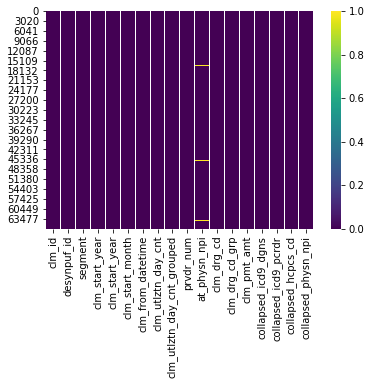

In [11]:
sns.heatmap(model_df.isnull(), cmap = 'viridis')
print(model_df.columns)
model_df.head()

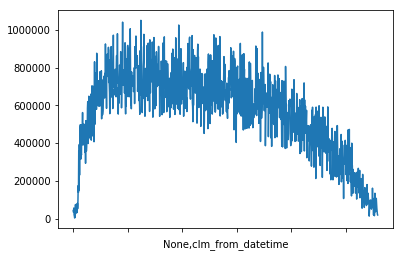

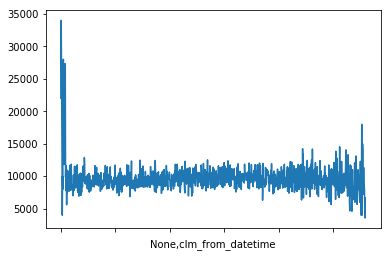

In [12]:
ts_data_temp = model_df.loc[:,['clm_from_datetime','clm_pmt_amt']]
ts_data_temp = ts_data_temp.groupby(['clm_from_datetime']).sum()
ts_data_temp = ts_data_temp.unstack()
ts_data_temp.plot()
plt.show()

ts_data_temp = model_df.loc[:,['clm_from_datetime','clm_pmt_amt']]
ts_data_temp = ts_data_temp.groupby(['clm_from_datetime']).mean()
ts_data_temp = ts_data_temp.unstack()
ts_data_temp.plot()
plt.show()

(343858, 4)
(116395, 4)
        desynpuf_id bene_birth_dt bene_sex_ident_cd bene_race_cd
0  00000B48BCF4AD29      19230901                 2            5
1  0000525AB30E4DEF      19201001                 2            1
2  00009C897C3D8372      19320101                 1            1
3  0001168CE43BE51B      19340901                 2            1
4  0002E494BC87CE10      19140701                 1            2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (116395, 19)
DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 22)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (114618, 19)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 40)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (112845, 19)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 58)
df shape - model df (66434, 18)
k shape - shape of keys df (116395, 58)
df head - model df            clm_id       desynpuf_id  segment  clm_start_year  clm_start_year  \
0  45461150060934  00000B48BCF4AD29        1            2008            2008   
1  45541150055035  00000B48BCF4AD29        1            2008            2008   
2  45731150068478  00000B48BCF4AD29        1            2008            2008   
3  45811150057351  0000525AB30E4DEF        1            2008            2008   
4  45391150058019  0000525AB30E4DEF        1            2008  

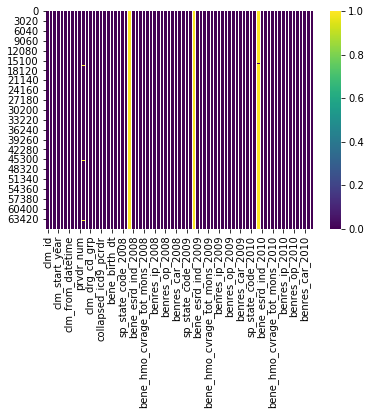

In [13]:
model_df = add_summary_info(summary_file_list, model_df)
sns.heatmap(model_df.isnull(), cmap = 'viridis')

In [14]:
print(model_df.columns)
model_df.head()


Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_year',
       'clm_start_month', 'clm_from_datetime', 'clm_utlztn_day_cnt',
       'clm_utlztn_day_cnt_grouped', 'prvdr_num', 'at_physn_npi', 'clm_drg_cd',
       'clm_drg_cd_grp', 'clm_pmt_amt', 'collapsed_icd9_dgns',
       'collapsed_icd9_pcrdr', 'collapsed_hcpcs_cd', 'collapsed_physn_npi',
       'bene_birth_dt', 'bene_sex_ident_cd', 'bene_race_cd',
       'sp_state_code_2008', 'bene_county_cd_2008', 'bene_death_dt_2008',
       'bene_esrd_ind_2008', 'bene_hi_cvrage_tot_mons_2008',
       'bene_smi_cvrage_tot_mons_2008', 'bene_hmo_cvrage_tot_mons_2008',
       'plan_cvrg_mos_num_2008', 'medreimb_ip_2008', 'benres_ip_2008',
       'pppymt_ip_2008', 'medreimb_op_2008', 'benres_op_2008',
       'pppymt_op_2008', 'medreimb_car_2008', 'benres_car_2008',
       'pppymt_car_2008', 'chronic_condition_count_2008', 'sp_state_code_2009',
       'bene_county_cd_2009', 'bene_death_dt_2009', 'bene_esrd_ind_2009',
       'ben

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,...,medreimb_ip_2010,benres_ip_2010,pppymt_ip_2010,medreimb_op_2010,benres_op_2010,pppymt_op_2010,medreimb_car_2010,benres_car_2010,pppymt_car_2010,chronic_condition_count_2010
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,2008-07-07,11.0,Over 7 days,1000GD,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2008-07-24,2.0,0-3 days,1030RD,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,2008-08-05,15.0,Over 7 days,1001NA,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,2008-05-25,11.0,Over 7 days,3900MB,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,2008-09-18,6.0,4-7 days,3100JN,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0


In [49]:
for m in model_df.dtypes.index[model_df.dtypes == 'object']:
    if m not in ['desynpuf_id', 'bene_birth_dt','prvdr_num','clm_drg_cd','collapsed_icd9_dgns','collapsed_icd9_pcrdr','collapsed_physn_npi']:
        print(m)
        print(model_df[m].value_counts())

clm_utlztn_day_cnt_grouped
0-3 days       30602
4-7 days       22157
Over 7 days    13675
Name: clm_utlztn_day_cnt_grouped, dtype: int64
clm_drg_cd_grp
Other    27515
176        279
887        266
175        265
187        264
886        263
884        259
949        257
181        255
163        253
177        252
183        251
947        250
180        248
941        248
876        246
184        246
206        245
168        244
182        244
885        242
203        240
202        239
882        237
166        237
199        236
883        235
200        234
881        233
196        233
         ...  
334        109
658        109
380        108
387        108
556        108
672        108
698        108
348        107
379        106
345        106
355        106
329        105
374        105
671        105
653        105
684        104
388        104
669        104
372        104
668        104
623        104
656        103
357        103
335        102
697        102
666     

In [50]:
c = model_df.dtypes.index[model_df.dtypes != 'object'].sort_values()
yoy_cols = [st for st in c if re.findall('\d{4}', st) != []]
other_num_cols = [st for st in c if re.findall('\d{4}', st) == []]

In [51]:
## groups year columns together so we can see changes over time
n = 0
while n < len(yoy_cols):
    cols = yoy_cols[n:(n+3)]
    print(model_df.loc[:,cols].describe())
    n = n + 3

       bene_county_cd_2008  bene_county_cd_2009  bene_county_cd_2010
count         66434.000000         66250.000000         65678.000000
mean            378.347352           378.329947           378.200630
std             267.952670           267.894280           267.815066
min               0.000000             0.000000             0.000000
25%             150.000000           150.000000           150.000000
50%             341.000000           341.000000           340.000000
75%             570.000000           570.000000           570.000000
max             999.000000           999.000000           999.000000
       bene_death_dt_2008  bene_death_dt_2009  bene_death_dt_2010
count        1.840000e+02        5.720000e+02        9.660000e+02
mean         2.008088e+07        2.009069e+07        2.010067e+07
std          2.099310e+02        3.482625e+02        3.422066e+02
min          2.008020e+07        2.009010e+07        2.010010e+07
25%          2.008070e+07        2.009040e+07    

       pppymt_op_2008  pppymt_op_2009  pppymt_op_2010
count    66434.000000    66250.000000    65678.000000
mean        53.983954       57.342038       29.199123
std        521.567485      576.136758      401.421536
min          0.000000        0.000000        0.000000
25%          0.000000        0.000000        0.000000
50%          0.000000        0.000000        0.000000
75%          0.000000        0.000000        0.000000
max      14020.000000    14500.000000    14000.000000
       sp_state_code_2008  sp_state_code_2009  sp_state_code_2010
count        66434.000000        66250.000000        65678.000000
mean            25.784749           25.780257           25.785255
std             14.969965           14.972691           14.976855
min              1.000000            1.000000            1.000000
25%             11.000000           11.000000           11.000000
50%             25.000000           25.000000           25.000000
75%             38.000000           38.000000       

In [52]:
n = 0
while n < len(other_num_cols):
    cols = other_num_cols[n:(n+3)]
    print(model_df.loc[:,cols].describe())
    n = n + 3

       at_physn_npi        clm_id
count  6.582200e+04  6.643400e+04
mean   5.057975e+09  4.549849e+13
std    2.914929e+09  2.847276e+11
min    2.977760e+05  4.501115e+13
25%    2.482526e+09  4.525115e+13
50%    4.986923e+09  4.550115e+13
75%    7.668307e+09  4.574115e+13
max    9.999956e+09  4.599115e+13
        clm_pmt_amt  clm_start_month  clm_start_year  clm_start_year
count  66434.000000     66434.000000    66434.000000    66434.000000
mean    9523.033838         6.277554     2008.784086     2008.784086
std     9184.010360         3.356556        0.763096        0.763096
min   -10000.000000         1.000000     2007.000000     2007.000000
25%     4000.000000         3.000000     2008.000000     2008.000000
50%     7000.000000         6.000000     2009.000000     2009.000000
75%    11000.000000         9.000000     2009.000000     2009.000000
max    57000.000000        12.000000     2010.000000     2010.000000
       clm_start_year  clm_start_year  clm_utlztn_day_cnt  segment
count 

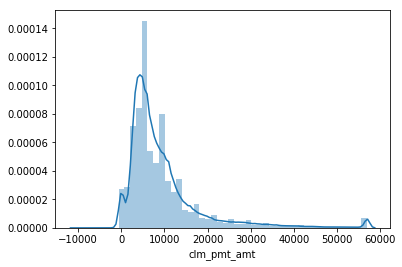

In [15]:
sns.distplot(model_df.clm_pmt_amt)

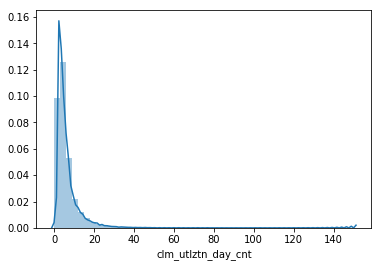

In [16]:
sns.distplot(model_df.clm_utlztn_day_cnt)

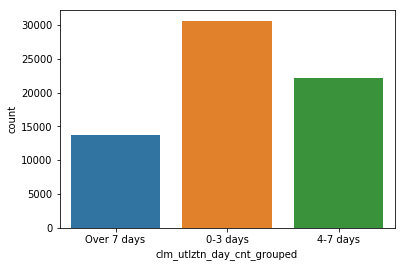

In [17]:
sns.countplot(model_df.clm_utlztn_day_cnt_grouped)

In [18]:
model_df.columns

Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_year',
       'clm_start_month', 'clm_from_datetime', 'clm_utlztn_day_cnt',
       'clm_utlztn_day_cnt_grouped', 'prvdr_num', 'at_physn_npi', 'clm_drg_cd',
       'clm_drg_cd_grp', 'clm_pmt_amt', 'collapsed_icd9_dgns',
       'collapsed_icd9_pcrdr', 'collapsed_hcpcs_cd', 'collapsed_physn_npi',
       'bene_birth_dt', 'bene_sex_ident_cd', 'bene_race_cd',
       'sp_state_code_2008', 'bene_county_cd_2008', 'bene_death_dt_2008',
       'bene_esrd_ind_2008', 'bene_hi_cvrage_tot_mons_2008',
       'bene_smi_cvrage_tot_mons_2008', 'bene_hmo_cvrage_tot_mons_2008',
       'plan_cvrg_mos_num_2008', 'medreimb_ip_2008', 'benres_ip_2008',
       'pppymt_ip_2008', 'medreimb_op_2008', 'benres_op_2008',
       'pppymt_op_2008', 'medreimb_car_2008', 'benres_car_2008',
       'pppymt_car_2008', 'chronic_condition_count_2008', 'sp_state_code_2009',
       'bene_county_cd_2009', 'bene_death_dt_2009', 'bene_esrd_ind_2009',
       'ben

In [19]:
model_df.head()

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_from_datetime,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,...,medreimb_ip_2010,benres_ip_2010,pppymt_ip_2010,medreimb_op_2010,benres_op_2010,pppymt_op_2010,medreimb_car_2010,benres_car_2010,pppymt_car_2010,chronic_condition_count_2010
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,2008-07-07,11.0,Over 7 days,1000GD,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2008-07-24,2.0,0-3 days,1030RD,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,2008-08-05,15.0,Over 7 days,1001NA,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,2008-05-25,11.0,Over 7 days,3900MB,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,2008-09-18,6.0,4-7 days,3100JN,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0


In [20]:
model_df.groupby('clm_utlztn_day_cnt_grouped')['clm_pmt_amt'].mean()


clm_utlztn_day_cnt_grouped
0-3 days        7285.117313
4-7 days        9228.373877
Over 7 days    15008.481901
Name: clm_pmt_amt, dtype: float64

clm_utlztn_day_cnt_grouped
0-3 days        7285.117313
4-7 days        9228.373877
Over 7 days    15008.481901
Name: clm_pmt_amt, dtype: float64


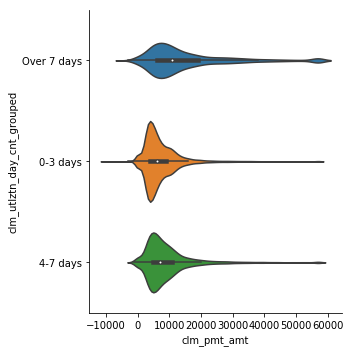

In [21]:
print(model_df.groupby('clm_utlztn_day_cnt_grouped')['clm_pmt_amt'].mean())
sns.catplot(x = 'clm_pmt_amt',
            y = 'clm_utlztn_day_cnt_grouped',
            kind = 'violin', #inner = 'stick',
           data = model_df[['clm_utlztn_day_cnt_grouped','clm_pmt_amt']])

# sns.catplot(x = 'clm_utlztn_day_cnt',
#             y = 'clm_utlztn_day_cnt_grouped',
#              kind = 'violin', #inner = 'stick',
#            data = model_df)

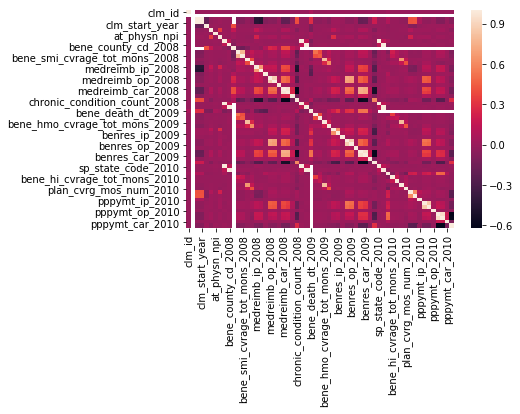

In [22]:
sns.heatmap(model_df.corr())

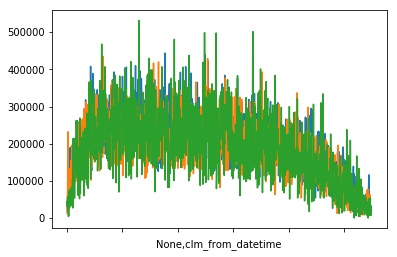

In [23]:
for level in model_df.clm_utlztn_day_cnt_grouped.value_counts().index:
    ts_data_temp = model_df.loc[model_df['clm_utlztn_day_cnt_grouped']== level,['clm_from_datetime','clm_pmt_amt']]
    ts_data_temp = ts_data_temp.groupby(['clm_from_datetime']).sum()
    ts_data_temp = ts_data_temp.unstack()
    ts_data_temp.plot()
plt.show()

In [59]:
model_df.columns
# network columns: desynpuf_id collapsed_physn_npi clm_pmt_amt clm_utlztn_day_cnt

def make_data_long(src, collapsed_dest, wgt, df):
    df = df.loc[:,[collapsed_dest, src, wgt]]
    x = df.assign(**{collapsed_dest:df[collapsed_dest].str.split(' ')}) 
    x.head()

    df = pd.DataFrame({col:np.repeat(x[col].values, x[collapsed_dest].str.len())
                        for col in x.columns.difference([collapsed_dest])
        }).assign(**{collapsed_dest:np.concatenate(x[collapsed_dest].values)})[x.columns.tolist()]
    
    # for blanks
    df = df[(df[src] != '') & (df[collapsed_dest] != '')]
    return df

df = make_data_long(src = 'desynpuf_id',
                    collapsed_dest = 'collapsed_physn_npi',
                    wgt = 'clm_pmt_amt',
                    df = model_df)

In [60]:
%%time
import networkx as nx
src = 'desynpuf_id'
collapsed_dest = 'collapsed_physn_npi'
wgt = 'clm_pmt_amt'
df = df

G = nx.MultiGraph()
G.add_weighted_edges_from(list(zip(df[src], df[collapsed_dest], df[wgt])))

Wall time: 855 ms


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


Wall time: 2h 54min 26s


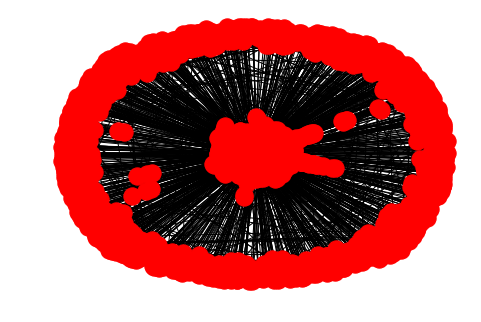

In [61]:
%%time
nx.draw(G)

In [62]:
print('avg degree connectivity:\n', nx.average_degree_connectivity(G))

avg degree connectivity:
 {6: 26.188155136268342, 1: 29.480668257756562, 67: 2.1641791044776117, 60: 3.2648148148148146, 27: 3.6009557945041815, 4: 32.772478296816864, 148: 3.222972972972973, 231: 2.74025974025974, 262: 1.7633587786259541, 113: 3.101769911504425, 110: 3.4272727272727272, 2: 39.04555597888206, 28: 3.44815668202765, 17: 5.595268542199489, 236: 3.5, 129: 3.0103359173126614, 118: 2.6836158192090394, 48: 3.488425925925926, 31: 3.1006451612903225, 19: 4.999177631578948, 5: 25.412340270171594, 8: 23.079239917269906, 14: 9.912315270935961, 7: 23.308161620812708, 33: 3.5844155844155843, 120: 1.8666666666666667, 71: 2.408450704225352, 26: 3.8736263736263736, 126: 2.757936507936508, 64: 3.01953125, 12: 15.687068965517241, 24: 3.8903508771929824, 92: 2.9239130434782608, 53: 3.5052410901467503, 13: 11.739010989010989, 239: 3.6317991631799162, 128: 2.8203125, 460: 2.2217391304347824, 282: 3.00354609929078, 3: 27.094227697923795, 96: 2.8229166666666665, 39: 3.217094017094017, 29: 3.6

In [63]:
# node level
print('avg neighborhood degree:\n', nx.average_neighbor_degree(G))

avg neighborhood degree:
 {'00000B48BCF4AD29': 26.0, '1219278332.0': 6.0, '7451661427.0': 6.0, '9812675420.0': 2.208955223880597, '6035410312.0': 3.7, '9404474617.0': 4.592592592592593, '0000525AB30E4DEF': 95.25, '1511429479.0': 4.0, '7340276481.0': 4.0, '3198317523.0': 3.222972972972973, '9156656040.0': 2.74025974025974, '00009C897C3D8372': 80.83333333333333, '4123724626.0': 1.7633587786259541, '5019745638.0': 2.7079646017699117, '4842645658.0': 3.4272727272727272, '000433285C8D2349': 2.0, '5131110383.0': 1.5, '0007DC6720F658B7': 22.5, '2571037543.0': 2.892857142857143, '675871414.0': 4.823529411764706, '0008148FCB4CB644': 92.5, '7872369581.0': 3.5, '5118340367.0': 4.054263565891473, '9000702378.0': 4.0, '2374022134.0': 4.25, '0009EB553C103F95': 118.0, '1237001783.0': 2.0084745762711864, '000B6900337D45AF': 39.5, '7663465047.0': 2.5208333333333335, '6948741155.0': 3.3870967741935485, '000C5BACF2F88B1E': 7.0, '4202272246.0': 1.9473684210526316, '9460144317.0': 3.5, '7285356841.0': 4.4,

In [67]:
df

,collapsed_physn_npi,desynpuf_id,clm_pmt_amt
0,1219278332.0,00000B48BCF4AD29,57000.0
1,7451661427.0,00000B48BCF4AD29,57000.0
2,9812675420.0,00000B48BCF4AD29,0.0
3,9812675420.0,00000B48BCF4AD29,0.0
4,6035410312.0,00000B48BCF4AD29,24000.0
5,9404474617.0,00000B48BCF4AD29,24000.0
6,1511429479.0,0000525AB30E4DEF,4000.0
7,7340276481.0,0000525AB30E4DEF,4000.0
8,3198317523.0,0000525AB30E4DEF,8000.0
9,9156656040.0,0000525AB30E4DEF,8000.0


             npi       beneficiary  clm_pmt_amt
10  4123724626.0  00009C897C3D8372       9000.0
12  4123724626.0  00009C897C3D8372      10000.0
14  4123724626.0  00009C897C3D8372       7000.0
15  4123724626.0  00009C897C3D8372       7000.0
13  4842645658.0  00009C897C3D8372      10000.0
11  5019745638.0  00009C897C3D8372        100.0


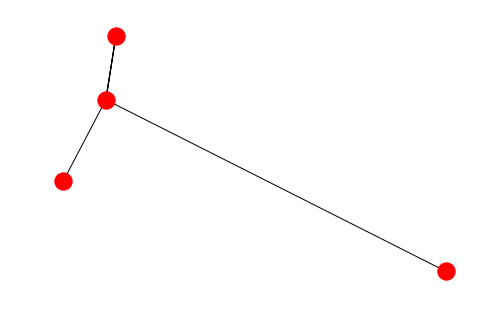

In [84]:
H = nx.MultiGraph()
df_example = df[df[src] == '00009C897C3D8372']
df_example.columns = ['npi','beneficiary','clm_pmt_amt']
print(df_example.sort_values(by='npi'))
H.add_weighted_edges_from(list(zip(df_example['npi'], 
                                   df_example['beneficiary'], 
                                   df_example['clm_pmt_amt'])))
nx.draw(H)
#labs = nx.draw_networkx_labels(G= H, pos = nx.spring_layout(H))
#print(labs)